<a href="https://colab.research.google.com/github/eoinleen/Protein-design-random/blob/main/ub2_BSA_analysis_plotting_needs_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing required packages...

Ubiquitin Interface Calculator with Enhanced Visualization
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Using the following parameters:
  Input directory: /content/drive/MyDrive/BindCraft/20250228-analysis_best_binders
  Ubiquitin chain: A
  Binder chain: B
  Contact cutoff: 4.5 Å
  Output file: results.csv

To change these parameters, edit the DEFAULT_* variables at the top of the script.
Found 17 PDB files to process.
Processing 3NOBEK_l113_s712433_mpnn3_model1(1).pdb...

INTERFACE ANALYSIS FOR K11-LINKED UBIQUITIN BINDER
Input PDB file: 3NOBEK_l113_s712433_mpnn3_model1(1).pdb
Binder name: l113_s712433_mpnn3

Contact Statistics:
  First Ubiquitin (residues 1-75):
    Atom contacts: 592
    Residue pairs: 29
    Unique Ub1 residues involved: 11
    Unique Binder residues involved: 11
    Average contact distance: 3.79 Å

  Second Ubiqu

<ipython-input-2-106155ccf090>:476: UserWarning:

Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations



Plot with built-in legend saved to /content/drive/MyDrive/BindCraft/20250228-analysis_best_binders/binding_preference_plot_with_legend.png


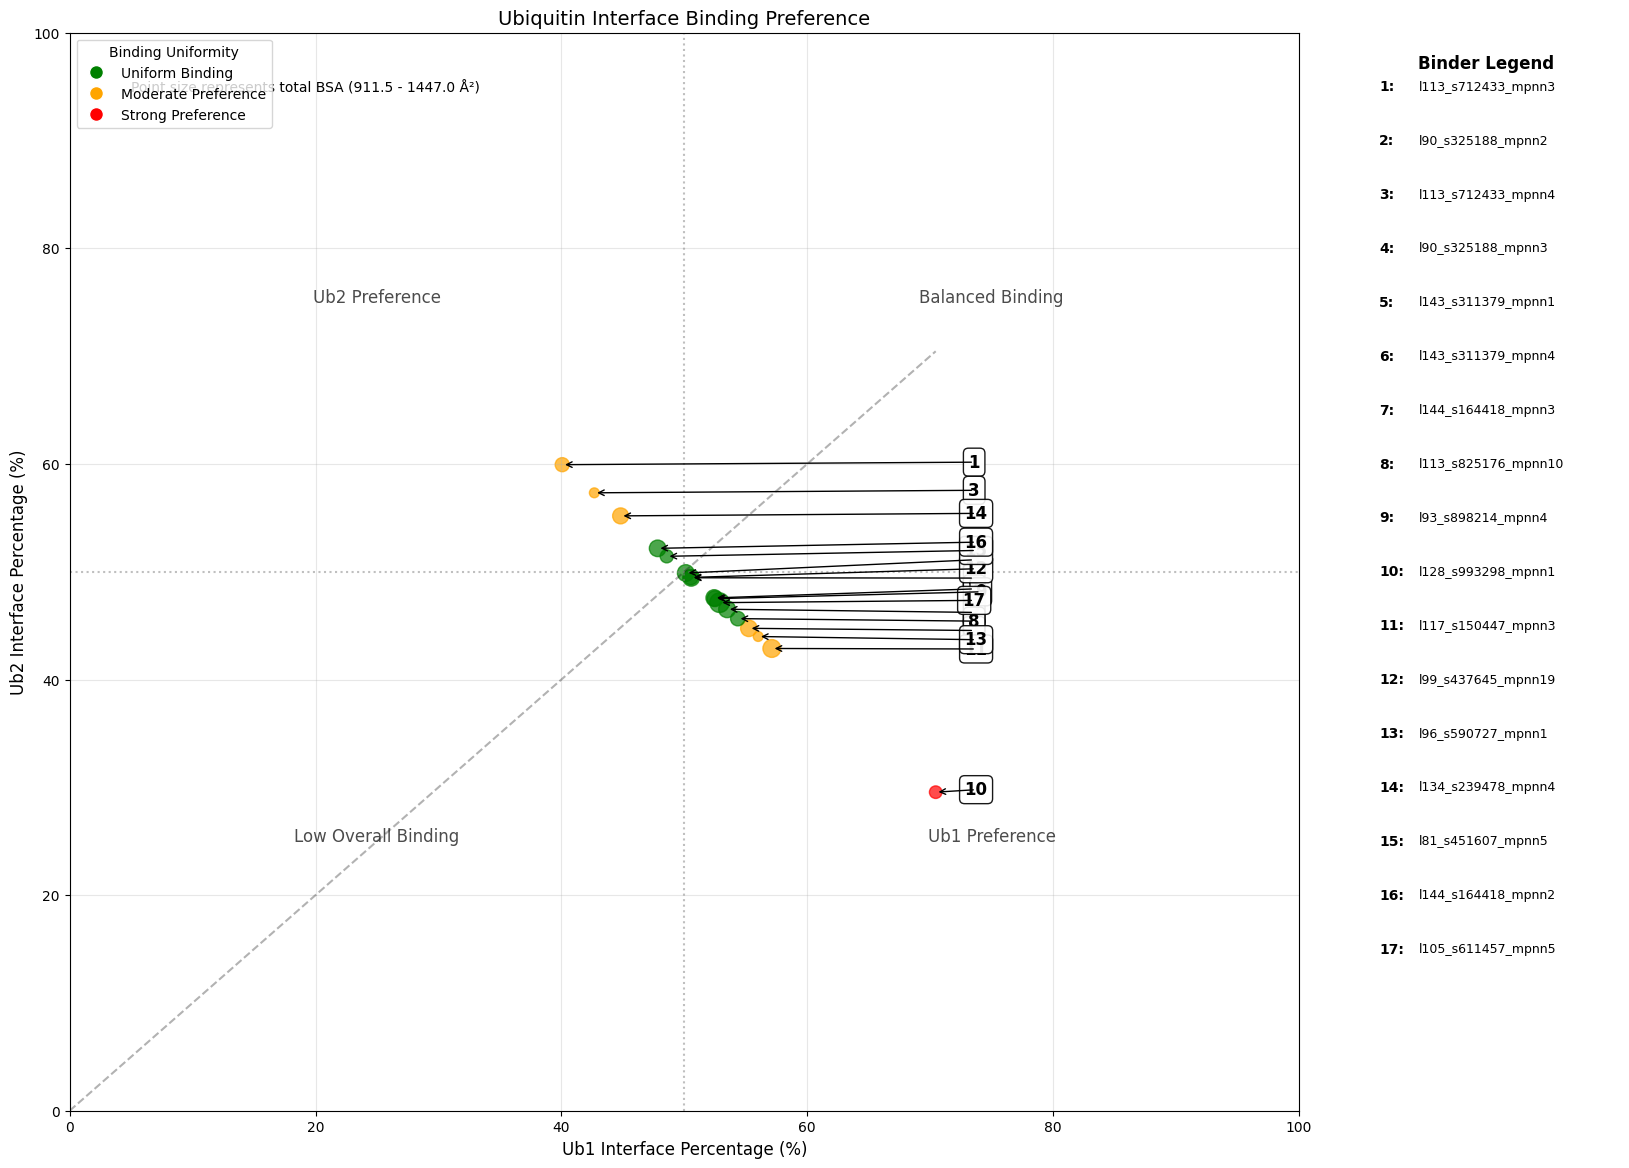


Creating interactive plot with built-in legend...
Interactive plot with legend saved to /content/drive/MyDrive/BindCraft/20250228-analysis_best_binders/interactive_binding_preference_with_legend.html
Interactive plot with legend saved as image to /content/drive/MyDrive/BindCraft/20250228-analysis_best_binders/binding_preference_with_legend.png


In [2]:
#!/usr/bin/env python

# Install required packages
!pip install adjustText plotly pandas kaleido -q

import sys
import os
import numpy as np
import csv
import re
from collections import defaultdict
from google.colab import drive
import glob
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, TextArea
from adjustText import adjust_text
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

"""
Script to calculate interface contacts between a binder and K11-linked diubiquitin.
This is a distance-based approach that doesn't require external tools like FreeSASA.

For K11-linked Ub2 where the two ubiquitin units are combined into a single chain,
this script will:
1. Split the specified ubiquitin chain into two parts: Ub1 (residues 1-75) and Ub2 (residues 126-201)
2. Count the number of atoms within a contact distance threshold between the binder and each Ub unit
3. Calculate the contact surface area (approximate BSA) and the percentage per Ub unit
4. Create enhanced scatter plots of Ub1 vs Ub2 percentages with built-in legends

This script can process multiple PDB files in a directory and supports Google Drive integration.
"""

# Default settings - these can be changed directly here
DEFAULT_INPUT_DIR = "/content/drive/MyDrive/BindCraft/20250228-analysis_best_binders"
DEFAULT_UB_CHAIN = "A"
DEFAULT_BINDER_CHAIN = "B"
DEFAULT_CUTOFF = 4.5
DEFAULT_OUTPUT_FILE = "results.csv"  # Will be saved in the input directory

def parse_pdb(pdb_file, ub_chain, binder_chain):
    """Parse PDB file and extract atom coordinates."""
    atoms = {
        'ub1': [],  # Ubiquitin chain, residues 1-75
        'ub2': [],  # Ubiquitin chain, residues 126-201
        'binder': [] # Binder chain
    }

    with open(pdb_file, 'r') as f:
        for line in f:
            if line.startswith('ATOM'):
                x = float(line[30:38])
                y = float(line[38:46])
                z = float(line[46:54])
                chain = line[21:22]
                residue_num = int(line[22:26])
                atom_name = line[12:16].strip()
                residue_name = line[17:20].strip()

                if chain == ub_chain and 1 <= residue_num <= 75:
                    atoms['ub1'].append({
                        'coords': np.array([x, y, z]),
                        'residue_num': residue_num,
                        'atom_name': atom_name,
                        'residue_name': residue_name
                    })
                elif chain == ub_chain and 126 <= residue_num <= 201:
                    atoms['ub2'].append({
                        'coords': np.array([x, y, z]),
                        'residue_num': residue_num,
                        'atom_name': atom_name,
                        'residue_name': residue_name
                    })
                elif chain == binder_chain:
                    atoms['binder'].append({
                        'coords': np.array([x, y, z]),
                        'residue_num': residue_num,
                        'atom_name': atom_name,
                        'residue_name': residue_name
                    })

    return atoms

def calculate_contacts(atoms1, atoms2, cutoff=4.5):
    """Calculate contacts between two sets of atoms within a distance cutoff."""
    contacts = []

    for atom1 in atoms1:
        for atom2 in atoms2:
            dist = np.linalg.norm(atom1['coords'] - atom2['coords'])
            if dist < cutoff:
                contacts.append({
                    'atom1': atom1,
                    'atom2': atom2,
                    'distance': dist
                })

    return contacts

def calculate_interface_stats(contacts):
    """Calculate interface statistics from contacts."""
    if not contacts:
        return {
            'contact_count': 0,
            'residue_pairs': 0,
            'avg_distance': 0,
            'unique_residues1': 0,
            'unique_residues2': 0
        }

    # Extract unique residue pairs
    residue_pairs = set()
    unique_res1 = set()
    unique_res2 = set()

    for contact in contacts:
        res1 = contact['atom1']['residue_num']
        res2 = contact['atom2']['residue_num']
        residue_pairs.add((res1, res2))
        unique_res1.add(res1)
        unique_res2.add(res2)

    # Calculate average distance
    avg_distance = sum(contact['distance'] for contact in contacts) / len(contacts)

    # Return statistics
    return {
        'contact_count': len(contacts),
        'residue_pairs': len(residue_pairs),
        'avg_distance': avg_distance,
        'unique_residues1': len(unique_res1),
        'unique_residues2': len(unique_res2)
    }

def estimate_bsa(contact_count, residue_pairs):
    """Estimate BSA based on number of contacts and residue pairs."""
    # This is a rough approximation based on the correlation between
    # contact counts and actual BSA
    return contact_count * 0.5 + residue_pairs * 5

def calculate_per_residue_contacts(contacts):
    """Calculate how many contacts each residue is involved in."""
    res1_contacts = defaultdict(int)
    res2_contacts = defaultdict(int)

    for contact in contacts:
        res1 = contact['atom1']['residue_num']
        res2 = contact['atom2']['residue_num']
        res1_contacts[res1] += 1
        res2_contacts[res2] += 1

    return res1_contacts, res2_contacts

def get_top_residues(residue_contacts, n=5):
    """Get the top N residues with the most contacts."""
    sorted_contacts = sorted(residue_contacts.items(), key=lambda x: x[1], reverse=True)
    return sorted_contacts[:n]

def extract_binder_name(filename):
    """Extract the core binder name from the filename."""
    # Try to match patterns like l113_s712433_mpnn3
    # This regex looks for patterns with underscores and alphanumeric characters
    match = re.search(r'([a-zA-Z]\d+(?:_[a-zA-Z]\d+)+(?:_[a-zA-Z]+\d+)?)', filename)
    if match:
        return match.group(1)

    # If no specific pattern is found, just return the filename without extension
    base = os.path.basename(filename)
    return os.path.splitext(base)[0]

def process_pdb_file(pdb_file, ub_chain, binder_chain, cutoff=4.5):
    """Process a single PDB file and return results as a dictionary."""
    # Parse PDB file
    atoms = parse_pdb(pdb_file, ub_chain, binder_chain)

    # Check if chains were found
    if not atoms['ub1'] or not atoms['ub2'] or not atoms['binder']:
        missing = []
        if not atoms['ub1']: missing.append(f"Ub1 (chain {ub_chain}, res 1-75)")
        if not atoms['ub2']: missing.append(f"Ub2 (chain {ub_chain}, res 126-201)")
        if not atoms['binder']: missing.append(f"Binder (chain {binder_chain})")

        print(f"Warning: Missing expected atoms in {pdb_file}: {', '.join(missing)}")

    # Calculate contacts
    ub1_binder_contacts = calculate_contacts(atoms['ub1'], atoms['binder'], cutoff)
    ub2_binder_contacts = calculate_contacts(atoms['ub2'], atoms['binder'], cutoff)

    # Calculate interface statistics
    ub1_stats = calculate_interface_stats(ub1_binder_contacts)
    ub2_stats = calculate_interface_stats(ub2_binder_contacts)

    # Estimate BSA
    ub1_bsa = estimate_bsa(ub1_stats['contact_count'], ub1_stats['residue_pairs'])
    ub2_bsa = estimate_bsa(ub2_stats['contact_count'], ub2_stats['residue_pairs'])
    total_bsa = ub1_bsa + ub2_bsa

    # Calculate percentages
    percentage_ub1 = (ub1_bsa / total_bsa) * 100 if total_bsa > 0 else 0
    percentage_ub2 = (ub2_bsa / total_bsa) * 100 if total_bsa > 0 else 0

    # Calculate per-residue contacts
    ub1_res_contacts, binder_ub1_contacts = calculate_per_residue_contacts(ub1_binder_contacts)
    ub2_res_contacts, binder_ub2_contacts = calculate_per_residue_contacts(ub2_binder_contacts)

    # Find top contact residues
    top_ub1_residues = get_top_residues(ub1_res_contacts)
    top_ub2_residues = get_top_residues(ub2_res_contacts)
    top_binder_residues = get_top_residues({**binder_ub1_contacts, **binder_ub2_contacts})

    # Determine binding uniformity
    diff = abs(percentage_ub1 - percentage_ub2)
    if diff < 10:
        uniformity = "Uniform"
    elif diff < 30:
        uniformity = "Moderate preference"
    else:
        uniformity = "Strong preference"

    # Format top residues as strings
    top_ub1_str = "; ".join([f"Res{res}:{count}" for res, count in top_ub1_residues])
    top_ub2_str = "; ".join([f"Res{res}:{count}" for res, count in top_ub2_residues])
    top_binder_str = "; ".join([f"Res{res}:{count}" for res, count in top_binder_residues])

    # Extract binder name from filename
    binder_name = extract_binder_name(pdb_file)

    # Create result dictionary
    result = {
        "pdb_file": os.path.basename(pdb_file),
        "binder_name": binder_name,
        "ub1_contacts": ub1_stats['contact_count'],
        "ub2_contacts": ub2_stats['contact_count'],
        "ub1_residue_pairs": ub1_stats['residue_pairs'],
        "ub2_residue_pairs": ub2_stats['residue_pairs'],
        "ub1_unique_residues": ub1_stats['unique_residues1'],
        "ub2_unique_residues": ub2_stats['unique_residues1'],
        "binder_ub1_unique_residues": ub1_stats['unique_residues2'],
        "binder_ub2_unique_residues": ub2_stats['unique_residues2'],
        "ub1_avg_distance": round(ub1_stats['avg_distance'], 2) if ub1_stats['avg_distance'] else 0,
        "ub2_avg_distance": round(ub2_stats['avg_distance'], 2) if ub2_stats['avg_distance'] else 0,
        "ub1_bsa": round(ub1_bsa, 2),
        "ub2_bsa": round(ub2_bsa, 2),
        "total_bsa": round(total_bsa, 2),
        "ub1_percentage": round(percentage_ub1, 2),
        "ub2_percentage": round(percentage_ub2, 2),
        "binding_uniformity": uniformity,
        "top_ub1_residues": top_ub1_str,
        "top_ub2_residues": top_ub2_str,
        "top_binder_residues": top_binder_str
    }

    return result

def print_result(result):
    """Print results for a single PDB file in a formatted way."""
    print("\n" + "="*70)
    print("INTERFACE ANALYSIS FOR K11-LINKED UBIQUITIN BINDER")
    print("="*70)
    print(f"Input PDB file: {result['pdb_file']}")
    print(f"Binder name: {result['binder_name']}")

    print("\nContact Statistics:")
    print(f"  First Ubiquitin (residues 1-75):")
    print(f"    Atom contacts: {result['ub1_contacts']}")
    print(f"    Residue pairs: {result['ub1_residue_pairs']}")
    print(f"    Unique Ub1 residues involved: {result['ub1_unique_residues']}")
    print(f"    Unique Binder residues involved: {result['binder_ub1_unique_residues']}")
    print(f"    Average contact distance: {result['ub1_avg_distance']} Å")

    print(f"\n  Second Ubiquitin (residues 126-201):")
    print(f"    Atom contacts: {result['ub2_contacts']}")
    print(f"    Residue pairs: {result['ub2_residue_pairs']}")
    print(f"    Unique Ub2 residues involved: {result['ub2_unique_residues']}")
    print(f"    Unique Binder residues involved: {result['binder_ub2_unique_residues']}")
    print(f"    Average contact distance: {result['ub2_avg_distance']} Å")

    print("\nEstimated Buried Surface Areas (Å²):")
    print(f"  First Ubiquitin-Binder Interface:  {result['ub1_bsa']}")
    print(f"  Second Ubiquitin-Binder Interface: {result['ub2_bsa']}")
    print(f"  Total Estimated BSA:               {result['total_bsa']}")

    print("\nPercentage of Total Interface:")
    print(f"  First Ubiquitin:  {result['ub1_percentage']}%")
    print(f"  Second Ubiquitin: {result['ub2_percentage']}%")

    print("\nTop Contact Residues:")
    print(f"  First Ubiquitin: {result['top_ub1_residues']}")
    print(f"  Second Ubiquitin: {result['top_ub2_residues']}")
    print(f"  Binder: {result['top_binder_residues']}")

    print("\nBinding Uniformity Assessment:")
    print(f"  {result['binding_uniformity']}")

    print("="*70)

def create_basic_plot(results, output_dir):
    """Create a basic scatter plot as fallback if enhanced plotting fails."""
    plt.figure(figsize=(12, 10))

    # Extract data for plotting
    x_values = [result['ub1_percentage'] for result in results]
    y_values = [result['ub2_percentage'] for result in results]
    labels = [result['binder_name'] for result in results]

    # Create scatter plot
    plt.scatter(x_values, y_values, alpha=0.7, s=100)

    # Add labels for each point
    for i, label in enumerate(labels):
        plt.annotate(label, (x_values[i], y_values[i]),
                     textcoords="offset points",
                     xytext=(0, 10),
                     ha='center',
                     fontsize=8)

    # Add diagonal line
    max_val = max(max(x_values), max(y_values))
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.3)

    # Add quadrant dividers
    plt.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
    plt.axvline(x=50, color='gray', linestyle=':', alpha=0.5)

    # Label the plot
    plt.xlabel('Ub1 Interface Percentage (%)', fontsize=12)
    plt.ylabel('Ub2 Interface Percentage (%)', fontsize=12)
    plt.title('Ubiquitin Interface Binding Preference', fontsize=14)

    # Add quadrant labels
    plt.text(25, 75, "Ub2 Preference", ha='center', fontsize=12, alpha=0.7)
    plt.text(75, 25, "Ub1 Preference", ha='center', fontsize=12, alpha=0.7)
    plt.text(75, 75, "Balanced Binding", ha='center', fontsize=12, alpha=0.7)
    plt.text(25, 25, "Low Overall Binding", ha='center', fontsize=12, alpha=0.7)

    # Set axis limits
    plt.xlim(0, 100)
    plt.ylim(0, 100)

    # Add grid
    plt.grid(True, alpha=0.3)

    # Save the plot
    plot_path = os.path.join(output_dir, "binding_preference_plot_basic.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Basic plot saved to {plot_path}")

    # Display the plot
    plt.show()


def create_enhanced_plot_with_legend(results, output_dir):
    """Create an enhanced scatter plot with numerical labels and a binder lookup legend."""
    try:
        import adjustText
        from adjustText import adjust_text
    except ImportError:
        print("Installing adjustText package for optimized label placement...")
        os.system("pip install adjustText")
        from adjustText import adjust_text

    # Create figure with appropriate size for legend
    plt.figure(figsize=(20, 14))

    # Create main plot area and legend area
    main_ax = plt.subplot2grid((1, 5), (0, 0), colspan=4)
    legend_ax = plt.subplot2grid((1, 5), (0, 4))

    # Extract data for plotting
    x_values = [result['ub1_percentage'] for result in results]
    y_values = [result['ub2_percentage'] for result in results]
    binder_names = [result['binder_name'] for result in results]

    # Create a mapping of binders to simple numbers
    binder_map = {name: i+1 for i, name in enumerate(binder_names)}
    numeric_labels = [str(binder_map[name]) for name in binder_names]

    # Determine point colors based on binding uniformity
    uniformity_categories = [result['binding_uniformity'] for result in results]
    color_map = {'Uniform': 'green', 'Moderate preference': 'orange', 'Strong preference': 'red'}
    colors = [color_map[cat] for cat in uniformity_categories]

    # Determine point sizes based on total BSA
    total_bsa_values = [result['total_bsa'] for result in results]
    min_bsa = min(total_bsa_values)
    max_bsa = max(total_bsa_values)
    size_range = max_bsa - min_bsa
    sizes = [50 + ((bsa - min_bsa) / size_range * 150) if size_range > 0 else 100 for bsa in total_bsa_values]

    # ===================== MAIN PLOT =====================
    # Create scatter plot with dynamic sizing and colors
    scatter = main_ax.scatter(x_values, y_values, c=colors, s=sizes, alpha=0.7)

    # Add numeric labels with optimized positioning
    texts = []
    for i, label in enumerate(numeric_labels):
        texts.append(main_ax.text(x_values[i], y_values[i], label,
                                fontsize=12, fontweight='bold',
                                bbox=dict(facecolor='white', alpha=0.9,
                                          edgecolor='black', boxstyle='round,pad=0.3')))

    # Use much stronger adjustment parameters to force better spacing
    adjust_text(texts,
              arrowprops=dict(arrowstyle='->', color='black', lw=1.0),
              expand_points=(3.0, 3.0),  # Increase spacing between points and text
              force_points=(0.5, 0.5),   # Increase force pushing text away from points
              force_text=(1.0, 1.0),     # Increase force pushing texts away from each other
              lim=500)                   # Increase the number of iterations for better layout

    # Add diagonal line representing equal percentages
    max_val = max(max(x_values), max(y_values))
    main_ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3)

    # Add quadrant dividers at 50%
    main_ax.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
    main_ax.axvline(x=50, color='gray', linestyle=':', alpha=0.5)

    # Label the plot
    main_ax.set_xlabel('Ub1 Interface Percentage (%)', fontsize=12)
    main_ax.set_ylabel('Ub2 Interface Percentage (%)', fontsize=12)
    main_ax.set_title('Ubiquitin Interface Binding Preference', fontsize=14)

    # Add quadrant labels
    main_ax.text(25, 75, "Ub2 Preference", ha='center', fontsize=12, alpha=0.7)
    main_ax.text(75, 25, "Ub1 Preference", ha='center', fontsize=12, alpha=0.7)
    main_ax.text(75, 75, "Balanced Binding", ha='center', fontsize=12, alpha=0.7)
    main_ax.text(25, 25, "Low Overall Binding", ha='center', fontsize=12, alpha=0.7)

    # Add a legend for the colors
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Uniform Binding'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Moderate Preference'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Strong Preference')
    ]
    main_ax.legend(handles=legend_elements, loc='upper left', title="Binding Uniformity")

    # Add size legend as text
    main_ax.text(5, 95, f"Point size represents total BSA ({min_bsa:.1f} - {max_bsa:.1f} Å²)",
             fontsize=10, ha='left', va='center')

    # Set axis limits
    main_ax.set_xlim(0, 100)
    main_ax.set_ylim(0, 100)

    # Add grid
    main_ax.grid(True, alpha=0.3)

    # ===================== LEGEND PANEL =====================
    # Turn off axes for legend panel
    legend_ax.axis('off')

    # Add binder lookup table as a text legend
    legend_ax.text(0.5, 0.98, "Binder Legend", fontsize=12, fontweight='bold',
                ha='center', va='top')

    # Create a sorted list of binder IDs and names
    sorted_binders = sorted([(binder_map[name], name) for name in binder_names])

    # Calculate vertical spacing
    y_pos = 0.95
    y_step = 0.85 / len(sorted_binders)

    # Add each binder to the legend
    for binder_id, binder_name in sorted_binders:
        if len(binder_name) > 20:
            # Truncate very long names
            binder_name = binder_name[:17] + "..."

        legend_ax.text(0.1, y_pos, f"{binder_id}:", fontsize=10, fontweight='bold', ha='left', va='center')
        legend_ax.text(0.25, y_pos, binder_name, fontsize=9, ha='left', va='center')
        y_pos -= y_step

    # Adjust layout to make room for everything
    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(output_dir, "binding_preference_plot_with_legend.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Plot with built-in legend saved to {plot_path}")

    # Display the plot
    plt.show()

    # Return the binder mapping for use in other functions
    return binder_map

def create_interactive_plot_with_legend(results, output_dir, binder_map=None):
    """Create an interactive Plotly scatter plot with numerical labels and a legend panel."""
    # Ensure required packages are installed
    try:
        import plotly.express as px
        import plotly.graph_objects as go
        import pandas as pd
    except ImportError:
        print("Installing required packages for interactive plotting...")
        os.system("pip install plotly pandas kaleido -q")
        import plotly.express as px
        import plotly.graph_objects as go
        import pandas as pd

    # If no binder map was provided, create one
    if binder_map is None:
        binder_names = [r['binder_name'] for r in results]
        binder_map = {name: i+1 for i, name in enumerate(binder_names)}

    # Create a pandas DataFrame for easier plotting with Plotly
    df = pd.DataFrame([{
        'binder_name': r['binder_name'],
        'label_number': binder_map[r['binder_name']],  # Add the numeric label
        'ub1_percentage': r['ub1_percentage'],
        'ub2_percentage': r['ub2_percentage'],
        'total_bsa': r['total_bsa'],
        'binding_uniformity': r['binding_uniformity'],
        'ub1_bsa': r['ub1_bsa'],
        'ub2_bsa': r['ub2_bsa'],
        'top_ub1_residues': r['top_ub1_residues'],
        'top_ub2_residues': r['top_ub2_residues'],
        'top_binder_residues': r['top_binder_residues']
    } for r in results])

    # Create a color mapping for binding uniformity
    color_discrete_map = {
        'Uniform': 'green',
        'Moderate preference': 'orange',
        'Strong preference': 'red'
    }

    # Create the main scatter plot
    fig = px.scatter(
        df,
        x='ub1_percentage',
        y='ub2_percentage',
        color='binding_uniformity',
        size='total_bsa',
        hover_name='binder_name',  # Full name on hover
        hover_data={
            'label_number': True,  # Show the number in hover data
            'ub1_percentage': ':.1f',
            'ub2_percentage': ':.1f',
            'total_bsa': ':.1f',
            'ub1_bsa': ':.1f',
            'ub2_bsa': ':.1f',
            'top_ub1_residues': True,
            'top_ub2_residues': True,
            'top_binder_residues': True
        },
        color_discrete_map=color_discrete_map,
        labels={
            'ub1_percentage': 'Ub1 Interface Percentage (%)',
            'ub2_percentage': 'Ub2 Interface Percentage (%)',
            'binding_uniformity': 'Binding Uniformity',
            'total_bsa': 'Total BSA (Å²)',
            'label_number': 'Binder #'
        },
        title='Ubiquitin Interface Binding Preference'
    )

    # Add diagonal line representing equal percentages
    max_val = max(df['ub1_percentage'].max(), df['ub2_percentage'].max())
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=max_val, y1=max_val,
        line=dict(color='gray', width=2, dash='dash')
    )

    # Add quadrant dividers at 50%
    fig.add_shape(
        type='line',
        x0=0, y0=50,
        x1=100, y1=50,
        line=dict(color='gray', width=1, dash='dot')
    )
    fig.add_shape(
        type='line',
        x0=50, y0=0,
        x1=50, y1=100,
        line=dict(color='gray', width=1, dash='dot')
    )

    # Add quadrant labels
    fig.add_annotation(x=25, y=75, text="Ub2 Preference", showarrow=False)
    fig.add_annotation(x=75, y=25, text="Ub1 Preference", showarrow=False)
    fig.add_annotation(x=75, y=75, text="Balanced Binding", showarrow=False)
    fig.add_annotation(x=25, y=25, text="Low Overall Binding", showarrow=False)

    # Add numeric text labels for each point
    for i, row in df.iterrows():
        fig.add_annotation(
            x=row['ub1_percentage'],
            y=row['ub2_percentage'],
            text=str(row['label_number']),  # Use the number instead of name
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=1,
            arrowcolor='black',
            ax=0,
            ay=-30,
            font=dict(size=10, color='black', weight='bold'),
            bgcolor='rgba(255, 255, 255, 0.8)'
        )

    # Create a sorted list of binder IDs and names for the legend
    sorted_binders = sorted([(binder_map[name], name) for name in binder_map.keys()])

    # Add legend with individual annotations for each entry
    y_pos = 0.95
    y_step = 1.8 / len(sorted_binders)

    # Add title for the legend
    fig.add_annotation(
        x=1.05, y=1.0,
        xref="paper", yref="paper",
        text="<b>Binder Legend</b>",
        showarrow=False,
        font=dict(size=14),
        align="center",
        bgcolor="white",
        bordercolor="black",
        borderwidth=1,
        borderpad=4
    )

    # Add each binder as a separate annotation
    for binder_id, binder_name in sorted_binders:
        if len(binder_name) > 20:
            binder_name = binder_name[:17] + "..."

        # Add entry to legend
        fig.add_annotation(
            x=1.05,
            y=y_pos - (binder_id-1)*y_step,
            xref="paper",
            yref="paper",
            text=f"<b>{binder_id}</b>: {binder_name}",
            showarrow=False,
            font=dict(size=11),
            align="left",
            bgcolor="white",
            bordercolor="lightgray",
            borderwidth=1,
            borderpad=3
        )

    # Update layout with more margin for legend
    fig.update_layout(
        xaxis=dict(range=[0, 100]),
        yaxis=dict(range=[0, 100]),
        xaxis_title='Ub1 Interface Percentage (%)',
        yaxis_title='Ub2 Interface Percentage (%)',
        legend_title='Binding Uniformity',
        font=dict(size=12),
        width=1200,  # Wider to accommodate legend
        height=750,
        margin=dict(r=300)  # Much more right margin
    )

    # Save as HTML
    html_path = os.path.join(output_dir, "interactive_binding_preference_with_legend.html")
    fig.write_html(html_path)
    print(f"Interactive plot with legend saved to {html_path}")

    # Save as PNG as well
    png_path = os.path.join(output_dir, "binding_preference_with_legend.png")
    fig.write_image(png_path, scale=3)
    print(f"Interactive plot with legend saved as image to {png_path}")

    # Display the plot in Colab
    fig.show()

def run_analysis(input_dir=DEFAULT_INPUT_DIR,
                output_file=DEFAULT_OUTPUT_FILE,
                ub_chain=DEFAULT_UB_CHAIN,
                binder_chain=DEFAULT_BINDER_CHAIN,
                cutoff=DEFAULT_CUTOFF):
    """Run the analysis with the given parameters."""

    # Ensure input directory exists
    if not os.path.exists(input_dir):
        print(f"Input directory '{input_dir}' does not exist. Creating it...")
        try:
            os.makedirs(input_dir, exist_ok=True)
            print(f"Directory created. Please add your PDB files to {input_dir} and run the script again.")
            return
        except Exception as e:
            print(f"Failed to create directory: {e}")
            return

    # Get full path for output file
    output_file_path = os.path.join(input_dir, output_file)

    # Get list of PDB files
    pdb_files = glob.glob(os.path.join(input_dir, "*.pdb"))
    if not pdb_files:
        print(f"No PDB files found in '{input_dir}'.")
        return

    print(f"Found {len(pdb_files)} PDB files to process.")

    # Process each PDB file
    results = []
    for pdb_file in pdb_files:
        print(f"Processing {os.path.basename(pdb_file)}...")
        result = process_pdb_file(pdb_file, ub_chain, binder_chain, cutoff)
        results.append(result)
        print_result(result)

    # Write results to CSV
    with open(output_file_path, 'w', newline='') as csvfile:
        if results:
            fieldnames = results[0].keys()
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for result in results:
                writer.writerow(result)

            print(f"\nResults written to {output_file_path}")
        else:
            print("No results to write to CSV.")

    # Create visualizations if we have results
    if results:
        print("\nCreating visualizations of binding preferences...")

        # Install required packages if needed
        try:
            # Try the enhanced visualization with built-in legend
            print("\nCreating enhanced plot with built-in legend...")
            binder_map = create_enhanced_plot_with_legend(results, input_dir)

            print("\nCreating interactive plot with built-in legend...")
            create_interactive_plot_with_legend(results, input_dir, binder_map)

        except Exception as e:
            print(f"Error creating enhanced visualizations: {e}")
            # Fall back to basic plot
            print("Creating basic visualization...")
            create_basic_plot(results, input_dir)

# Main execution - this will run when the script is executed in Colab
if __name__ == "__main__":
    # Install required packages first
    print("Installing required packages...")
    os.system("pip install adjustText plotly pandas kaleido -q")

    print("\nUbiquitin Interface Calculator with Enhanced Visualization")
    print("="*60)

    # Mount Google Drive
    try:
        drive.mount('/content/drive')
        print("Google Drive mounted successfully.")
    except Exception as e:
        print(f"Error mounting Google Drive: {e}")
        print("This script is designed to run in Google Colab with Google Drive.")
        sys.exit(1)

    # Run analysis with default parameters
    print(f"Using the following parameters:")
    print(f"  Input directory: {DEFAULT_INPUT_DIR}")
    print(f"  Ubiquitin chain: {DEFAULT_UB_CHAIN}")
    print(f"  Binder chain: {DEFAULT_BINDER_CHAIN}")
    print(f"  Contact cutoff: {DEFAULT_CUTOFF} Å")
    print(f"  Output file: {DEFAULT_OUTPUT_FILE}")
    print("\nTo change these parameters, edit the DEFAULT_* variables at the top of the script.")
    print("="*60)

    run_analysis()